# Poiseulle flow 
The Poiseulle flow is the flow between 2 infinite planes (is also called: Channel flow)

Let's solve the N-S equatoions using the IPCS method 

This method involves solving 3 linear problem in succesion:

1) Find an approximative velocity (u*)
2) Find the pressure (p_n+1)
3) Find the real veocity (u_n+1)

In [1]:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import pyvista

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter
from dolfinx.mesh import create_unit_square
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym)

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10) #Definisco quindi un dominio quadrato 
t = 0
T = 20
num_steps = 500
dt = T / num_steps

Taylor-Hood element:


It is well-known that certain finite element spaces are not stable for the Navier-Stokes equations, or even for the simpler Stokes equation. The prime example of an unstable pair of finite element spaces is to use first order degree continuous piecewise polynomials for both the velocity and the pressure. Using an unstable pair of spaces typically results in a solution with spurious (unwanted, non-physical) oscillations in the pressure solution. The simple remedy is to use continuous piecewise quadratic elements for the velocity and continuous piecewise linear elements for the pressure. 

In [ ]:
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, )) 
# 2 indicates that we will have QUADRATIC vector functions on the single element
# shape=(mesh.geometry.dim, ) instead, is used to set the dimension of v_cg2 equal to the 
# number of dimensions as the domain (so the velocity will be a 2D vector, with 2 components: u, v)

s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
# mesh.topology.cell_name() --> returns the name of the type of cell of the mesh we are using
# (in this case "triangle"); so that the vector space I will create takes this into account


# Now I create the vector spaces for velocity and pressure
V = functionspace(mesh, v_cg2)
Q = functionspace(mesh, s_cg1)

We will use homogeneous Dirichlet Boundary conditions at the top and bottom boundaries

which in practice (given the type of problem) will be no-slip conditions

u=0 at y=0 and y=1 (Recall that I have a square domain [0,1]x[0,1])

In [ ]:
# define the variables of interest
u = TrialFunction(V) 
v = TestFunction(V) # test function related to the velocity 
p = TrialFunction(Q)
q = TestFunction(Q) # test function related to the pressure 

In [4]:
# now I define the top and bottom boundaries
def walls(x):
    return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], 1))

In [5]:
wall_dofs = locate_dofs_geometrical(V, walls)

u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define a 2D array (all zeros!!! Because I have homogeneous Dirichlet BCs on these boundaries)
bc_noslip = dirichletbc(u_noslip, wall_dofs, V)

Now I define the BCs for the pressure

That is, I define:

p=8 at the inflow (i.e. for x=0)

p=0 at the outflow (i.e. for x=1) 

In [6]:
def inflow(x):
    return np.isclose(x[0], 0)

inflow_dofs = locate_dofs_geometrical(Q, inflow)
bc_inflow = dirichletbc(PETSc.ScalarType(8), inflow_dofs, Q)

In [7]:
def outflow(x):
    return np.isclose(x[0], 1)

outflow_dofs = locate_dofs_geometrical(Q, outflow)
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)

# now I define the array that contains the various BCs
bcu = [bc_noslip]  # BCs related to velocity (on the top and bottom boundaries)
bcp = [bc_inflow, bc_outflow] # BCs related to pressure (on inflow and outflow)


Recall that I am trying to solve the N-S equations using the IPCS scheme

So, 1 time-step of the NS will be solved by solving 3 linear problems:

1) Calculation of the approximated velocity u* (using the pressure calculated at the previous time-step p_n) ---> via the momentum eq in variational form
2) Calculation of the new pressure p_n+1 (using the just calculated approximated velocity u*) ---> via a kind of Poisson equation
3) Calculation of the true velocity at the new timestep u_n+1 (using p_n, p_n+1 and u*) ---> via a kind of Poisson equation

1) STEP 1

I now define the first variational problem:
⟨rho*(u*u_n)/dt, v⟩ + ⟨rho*dot(u_n,nabla_grad(u_n)), v⟩ + ⟨σ(u_n+1/2,p_n), ϵ(v)⟩ + ⟨p_n*n,v⟩deltaOmega - ⟨mu * dot(nabla_grad(u_n+1/2),n), v⟩deltaOmega = ⟨f_n+1,v⟩

In [ ]:
from dolfinx.fem import Function

u_n = Function(V)  # when a variable is neither the trial nor the test function, it is defined this way!
u_n.name = "u_n"

U = 0.5 * (u_n + u) # U will therefore be u_n+1/2 (since u==u_n+1)

n = FacetNormal(mesh) # in this way I define the normal vector to the boundaries n

from dolfinx.fem import Constant
from petsc4py import PETSc

# Let's define all the costants that we will use 
f = Constant(mesh, PETSc.ScalarType((0, 0))) # source term f=0
k = Constant(mesh, PETSc.ScalarType(dt)) # k will be equal to the time-step dt (wtf)???????????
mu = Constant(mesh, PETSc.ScalarType(1)) # I assume unit viscosity (mu=1)
rho = Constant(mesh, PETSc.ScalarType(1)) # I assume unit density (rho=1)

In [9]:
# now I define the variational problem

# Define strain-rate tensor ϵ(..)
def epsilon(u):
    return sym(nabla_grad(u)) # sym takes only the symmetric part

# Define stress tensor σ(u,p)
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))


# Define the variational problem for the first step
p_n = Function(Q)
p_n.name = "p_n" # p_n will be the p at the "previous" step (p_n)

# Recall that since I am calculating an approximated u, u*, then u* in the eqs will replace
# the actual new u, i.e. u_n+1 (which in this case was represented by the trial function u)
F1=rho*dot((u-u_n)/k,v)*dx   # I use k instead of dt because who knows
F1+=rho*dot(dot(u_n,nabla_grad(u_n)),v)*dx
F1+=inner(sigma(U,p_n),epsilon(v))*dx # we use inner because we are doing the product between two functions: σ(u_n+1/2,p_n) and ϵ(v)!!!
F1+=dot(p_n*n,v)*ds -dot(mu*nabla_grad(U)*n,v)*ds # mu could also be placed outside the dot product (since it is a simple scalar)
F1-=dot(f,v)*dx

# now I define the classic form: a(u,v)=L(v)
a1=form(lhs(F1))
L1=form(rhs(F1))

In [10]:
# given my particular discretization a1 (i.e. a(u,v) will have to be assembled only once as it will not depend on time)
# unlike L1 (L(u,v)) which will instead depend on u_n and p_n!!!

# So I define a fixed matrix for a(u,v)
A1 = assemble_matrix(a1, bcs=bcu)
A1.assemble()
b1 = create_vector(L1)

2) STEP 2

Calculation of the new pressure p_n+1 (using the just calculated approximated velocity u*) ---> via a kind of Poisson equation


In [11]:
# Define variational problem for step 2
u_ = Function(V)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

3) STEP 3

Calculation of the true velocity at the new timestep u_n+1 (using p_n, p_n+1 and u*) ---> via a kind of Poisson equation

In [12]:
# Define variational problem for step 3
p_ = Function(Q)
a3 = form(rho * dot(u, v) * dx)
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

Now that we have defined all the necessary structures for the linear problems, we can create the various solvers using PETSc (we can also customize the solution strategy for each problem)

For the tentative velocity step and pressure correction step, we will use the Stabilized version of BiConjugate Gradient to solve the linear system, and use algebraic multigrid for preconditioning.

For the last step, the velocity update, we use a conjugate gradient method with successive over relaxation, Gauss Seidel (SOR) preconditioning.

In [13]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

We prepare output files for the velocity and pressure data, and write the mesh and initial conditions to file

In [14]:
from pathlib import Path
folder = Path("results_poiseulle")
folder.mkdir(exist_ok=True, parents=True)

# VTXWriter: is an object that writes FEM data to file in ADIOS2 .bp format.
# So I create 2 .bp files:
# poiseuille_u.bp
# poiseuille_p.bp
vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")

# associate the time t
vtx_u.write(t) 
vtx_p.write(t)

When you write a .bp file with engine="BP4" (as in VTXWriter), a single readable text file is not created,

but a binary container divided into several "physical" files.

This is normal and expected from the internal functioning of ADIOS2.

So, for example, inside the directory "poiseuille_u.bp", you will find:

-data.0    <---Contains the raw binary numerical data (i.e. values of the FEM fields, vectors, etc.).

-md.0    <---Contains the metadata (description of the content, variable names, topology).

-md.idx  <---Is a quick index of the metadata, used for efficient access and parallelization.

All together, these 3 files make up the .bp file, and must be treated as a whole.



In ParaView, you can directly open poiseuille_u.bp and ParaView will correctly interpret data.0, md.0, and md.idx.


COMPARISON WITH ANALYTICAL SOLUTION

I know that for this particular type of flow, i.e. Poiseuille flow,
there is an analytical solution, namely:

p(x)=8*(1-x)

ux(x)=4*y(1-y)

I will now interpolate the analytical solution in our vector space, and then compare it with the solution
of our variational problem.

In [15]:
def u_exact(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType) # create a 2D null vector for the velocities
    values[0] = 4 * x[1] * (1.0 - x[1]) # I know that ux(x)=4y(1-y)
    return values


u_ex = Function(V)
u_ex.interpolate(u_exact)

L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx)

I will now create the loop that solves the Poiseuille problem, i.e. that successively solves
the linear problems I defined earlier:

In [16]:
for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative velocity step
    # update the vector b1 (which depends on L1(u,v), and therefore changes at each time-step)
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)

    solver1.solve(b1, u_.x.petsc_vec)
    u_.x.scatter_forward()

    # Step 2: Pressure correction step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, p_.x.petsc_vec)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.x.petsc_vec)
    u_.x.scatter_forward()

    
    # Update variable with solution from this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Compute error at current time-step
    error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
    error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step
    if (i % 20 == 0) or (i == num_steps - 1):
        print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
# Close xmdf file
vtx_u.close()
vtx_p.close()

b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

Time 0.04, L2-error 4.57e-01, Max error 3.20e-01
Time 0.84, L2-error 5.83e-04, Max error 1.69e-03
Time 1.64, L2-error 1.92e-04, Max error 1.03e-03
Time 2.44, L2-error 9.45e-05, Max error 5.96e-04
Time 3.24, L2-error 5.30e-05, Max error 3.73e-04
Time 4.04, L2-error 3.23e-05, Max error 2.51e-04
Time 4.84, L2-error 2.12e-05, Max error 1.80e-04
Time 5.64, L2-error 1.50e-05, Max error 1.36e-04
Time 6.44, L2-error 1.15e-05, Max error 1.08e-04
Time 7.24, L2-error 9.52e-06, Max error 8.89e-05
Time 8.04, L2-error 8.29e-06, Max error 8.15e-05
Time 8.84, L2-error 7.48e-06, Max error 7.93e-05
Time 9.64, L2-error 6.88e-06, Max error 7.66e-05
Time 10.44, L2-error 6.39e-06, Max error 7.42e-05
Time 11.24, L2-error 5.97e-06, Max error 7.14e-05
Time 12.04, L2-error 5.59e-06, Max error 6.81e-05
Time 12.84, L2-error 5.23e-06, Max error 6.44e-05
Time 13.64, L2-error 4.89e-06, Max error 6.05e-05
Time 14.44, L2-error 4.57e-06, Max error 5.64e-05
Time 15.24, L2-error 4.27e-06, Max error 5.22e-05
Time 16.04, L

VISUALIZATION OF THE VECTORS

Let's see how to visualize vector functions using glyphs

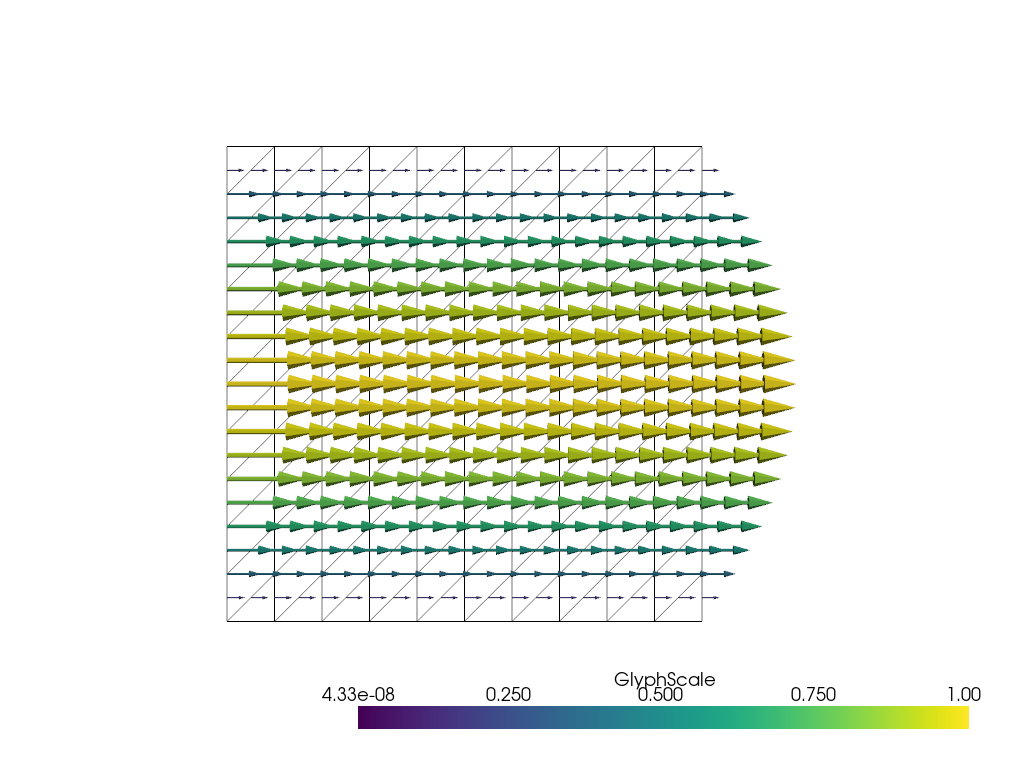

In [17]:
#pyvista.start_xvfb()  # to use only if running in a docker container

from dolfinx.plot import vtk_mesh

topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")